### Educational analytic case with McDonalds and Starbucks menu: what would be better as meals for teens?

[Case description]

DONE:
- values from norms (document-1) extracted manually --> txt --> dict. We find only 6 values: Energy(kcal), Fat(g), Carbohydrates(g), Fiber(g), Protein(g), Sodium (g), wich exist in all three datasets (document-1, McD and SB menus)
- values from McD and SB .csv menus --> Excel --> (processing: combine, add features in cols, enrichment)
- features added: (1) 'McD=0_SB=1': restraunt coding, (2) 'Category': food/drink, (3) 'Kind': bakery/breakfast/hot drink etc.
- dataset enriched manually: about 60 items in 'Snacks & sweets' category were added for SB menu. Thus we have more balanced dataaset (McD/SB share).
- discard from zeroes: dividing all mass values by 1000 (mg --> g)
- several bug fixes in values

PLAN:
- deleting (1) dish with 1880 kcal (40 pieces of chicken nuggets), (2) items with all zeroes, (3) items such as gums and mints. It's irrelevant for the task
- pool together several 'Kinds' within 'Snacks & sweets' category with only a few items in SB menu
- calculate the weighted norms - according the rule requirement from official document-2
- add the data on serving sizes
- look on full menus list. If need discard from all that irrelevant (very large served size / caloric or nutrition values exceed official weighted norms / include potential allergics)
- search for nutrition indices or calculate integrated nutrition index (may be Carb:Fat:Prot matching those in norms?) and visualize it
- develop the decision making algorithm for combining potential breakfast and dinner sets 
- test the algorithm, corrections
- extract the results, preference for hot dishes and moderate-sugared drinks

In [318]:
# required imports
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [319]:
# Starbucks (SB) and McDonalds (McD) combined menu in single df: 
menu_df = pd.read_csv ('combined_menu_300919.csv', sep=';', encoding = 'koi8-r')
menu_df.head()

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium (g)
0,1,food,Bakery,Chonga Bagel,300,5.0,50,3.0,12,0.53
1,1,food,Bakery,8-Grain Roll,380,6.0,70,7.0,10,0.43
2,1,food,Bakery,Almond Croissant,410,22.0,45,3.0,10,0.39
3,1,food,Bakery,Banana Nut Bread,420,22.0,52,2.0,6,0.32
4,1,food,Bakery,Birthday Cake Pop,170,9.0,23,0.0,1,0.11


In [320]:
# checking data gaps - it's OK
menu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 10 columns):
McD=0_SB=1          502 non-null int64
Category            502 non-null object
Kind                502 non-null object
Item                502 non-null object
Energy(kcal)        502 non-null int64
Fat(g)              502 non-null float64
Carbohydrates(g)    502 non-null int64
Fiber(g)            502 non-null float64
Protein(g)          502 non-null int64
Sodium (g)          502 non-null float64
dtypes: float64(3), int64(4), object(3)
memory usage: 39.3+ KB


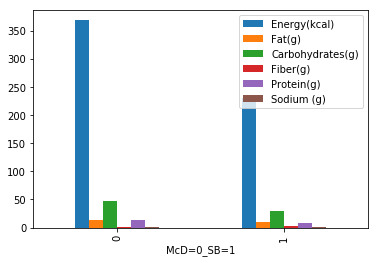

In [321]:
# all mean nutrition facts for McD and SB menu
means = menu_df.groupby ('McD=0_SB=1').mean()
means.plot(kind = 'bar')

In [322]:
# food/drinks/kind in SB and McD? Detailed data:
means_SB = menu_df.iloc[1:242].groupby (['McD=0_SB=1', 'Category', 'Kind']).mean()
means_McD = menu_df.iloc[242:].groupby (['McD=0_SB=1', 'Category', 'Kind']).mean()

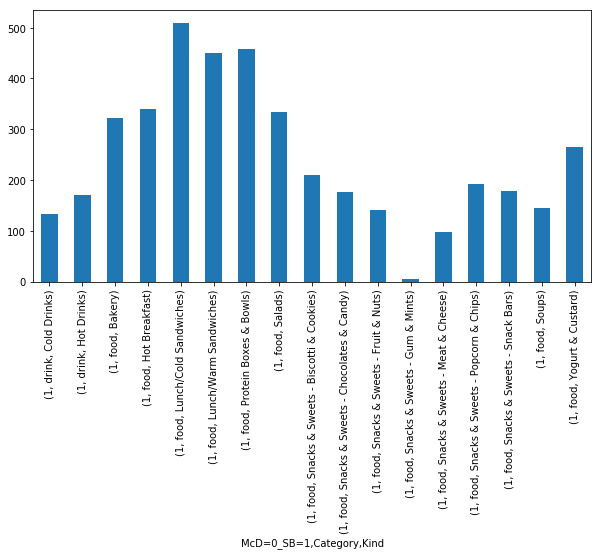

In [323]:
# mean caloric values for SB item groups (== Kinds)
means_SB['Energy(kcal)'].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 0.5, figsize = (10,5))

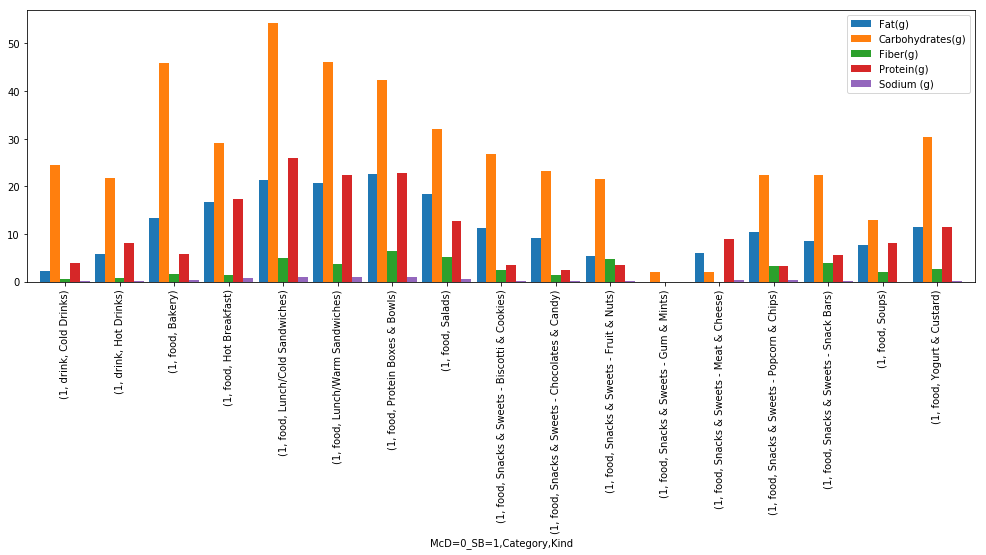

In [324]:
# mean nutrition values for SB item groups (== Kinds)
means_SB[['Fat(g)', 
          'Carbohydrates(g)', 
          'Fiber(g)', 
          'Protein(g)', 
          'Sodium (g)']].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 0.9, figsize = (17,5))

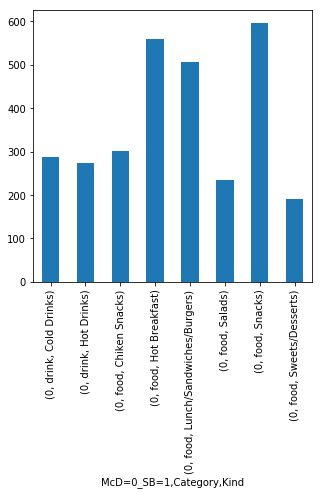

In [325]:
# mean caloric values for McD item groups (== Kinds)
means_McD['Energy(kcal)'].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 0.5, figsize = (5,5))

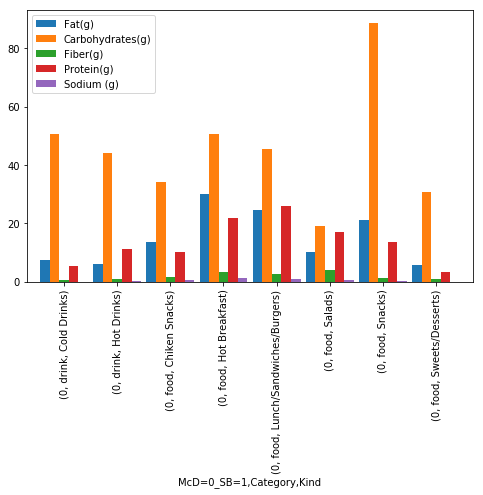

In [326]:
# mean nutrition values for McD item groups (== Kinds)
means_McD[['Fat(g)', 
           'Carbohydrates(g)', 
           'Fiber(g)', 
           'Protein(g)', 
           'Sodium (g)']].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 0.9, figsize = (8,5))

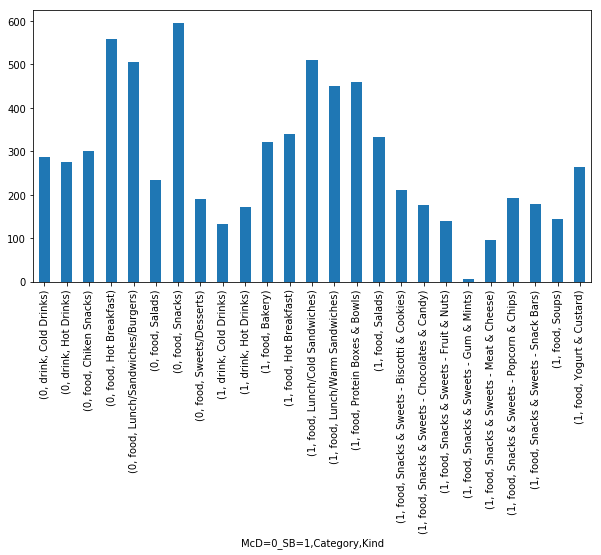

In [327]:
# Combined mean caloric values in SB + McD:
means_all = menu_df.groupby (['McD=0_SB=1', 'Category', 'Kind']).mean()
means_all['Energy(kcal)'].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 0.5, figsize = (10,5))

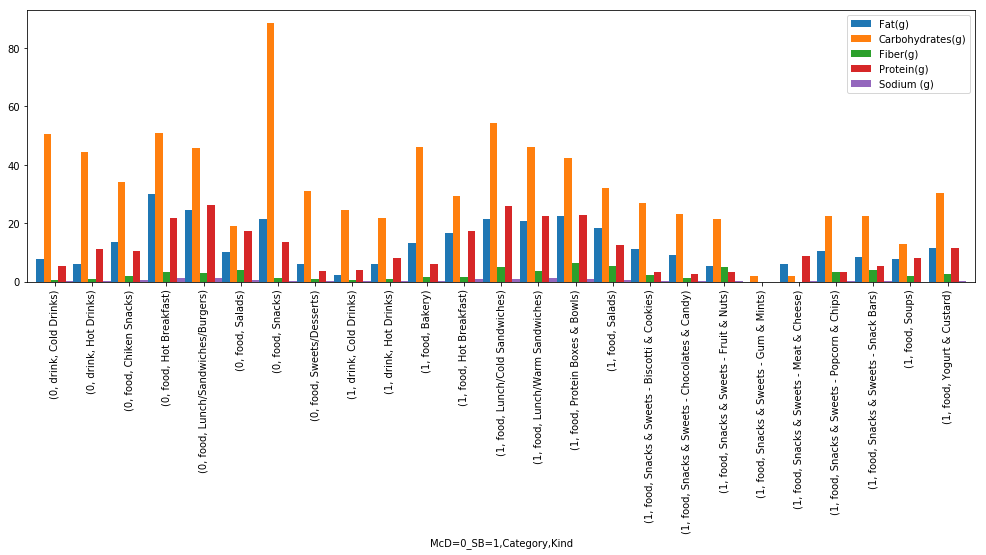

In [328]:
# Combined mean nutrition values in SB + McD:
means_all[['Fat(g)', 
          'Carbohydrates(g)', 
          'Fiber(g)', 
          'Protein(g)', 
          'Sodium (g)']].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 1, figsize = (17,5))

In [329]:
counts = menu_df.groupby (['McD=0_SB=1', 'Category']).count()
counts

Kind  Item  Energy(kcal)  Fat(g)  Carbohydrates(g)  \
McD=0_SB=1 Category                                                       
0          drink      142   142           142     142               142   
           food       118   118           118     118               118   
1          drink       84    84            84      84                84   
           food       158   158           158     158               158   

                     Fiber(g)  Protein(g)  Sodium (g)  
McD=0_SB=1 Category                                    
0          drink          142         142         142  
           food           118         118         118  
1          drink           84          84          84  
           food           158         158         158

### Restrictions from the task description
[Restrictions, document-1 = link, document-2 = link]

In [330]:
# RESTRICITION 1: Dict with actual norms (from official document-1)
norms = {}

f = open ('actual_norms.txt')

for line in f:
    line = line.strip().split(',')
    norms[line[0]] = line[1]
    
del norms['Item']
norms

{'Energy(kcal)': '2900',
 'Protein(mg)': '87000',
 'Fat(mg)': '97000',
 'Carbohydrates(mg)': '421000',
 'Fiber(mg)': '20000',
 'Sodium(mg)': '1300'}

In [331]:
# RESTRICITION 2 (rule from official document-2): 
# - breakfast + dinner = 20-25% + 30-35% daily energy value respectively
# - breakfast + dinner = 55-60% total daily nutrients value
# (only breakfast and dinner mentioned in the task)

In [332]:
means_all

Energy(kcal)  \
McD=0_SB=1 Category Kind                                                 
0          drink    Cold Drinks                             287.931034   
                    Hot Drinks                              274.545455   
           food     Chiken Snacks                           301.000000   
                    Hot Breakfast                           558.378378   
                    Lunch/Sandwiches/Burgers                506.382979   
                    Salads                                  234.285714   
                    Snacks                                  596.250000   
                    Sweets/Desserts                         191.111111   
1          drink    Cold Drinks                             132.045455   
                    Hot Drinks                              170.833333   
           food     Bakery                                  320.882353   
                    Hot Breakfast                           339.375000   
                    Lunch/Cold Sandwiches                   510.000000   
                    Lunch/Warm Sandwiches                   450.714286   
                    Protein Boxes & Bowls                   459.000000   
                    Salads                                  334.000000   
                    Snacks & Sweets - Biscotti & Cookies    210.000000   
                    Snacks & Sweets - Chocolates & Candy    177.000000   
                    Snacks & Sweets - Fruit & Nuts          140.000000   
                    Snacks & Sweets - Gum & Mints             5.000000   
                    Snacks & Sweets - Meat & Cheese          96.666667   
                    Snacks & Sweets - Popcorn & Chips       192.500000   
                    Snacks & Sweets - Snack Bars            177.692308   
                    Soups                                   145.000000   
                    Yogurt & Custard                        264.285714   

                                                             Fat(g)  \
McD=0_SB=1 Category Kind                                              
0          drink    Cold Drinks                            7.557471   
                    Hot Drinks                             6.045455   
           food     Chiken Snacks                         13.500000   
                    Hot Breakfast                         30.027027   
                    Lunch/Sandwiches/Burgers              24.531915   
                    Salads                                10.071429   
                    Snacks                                21.250000   
                    Sweets/Desserts                        5.944444   
1          drink    Cold Drinks                            2.242424   
                    Hot Drinks                             5.833333   
           food     Bakery                                13.088235   
                    Hot Breakfast                         16.687500   
                    Lunch/Cold Sandwiches                 21.333333   
                    Lunch/Warm Sandwiches                 20.642857   
                    Protein Boxes & Bowls                 22.600000   
                    Salads                                18.400000   
                    Snacks & Sweets - Biscotti & Cookies  11.153846   
                    Snacks & Sweets - Chocolates & Candy   9.200000   
                    Snacks & Sweets - Fruit & Nuts         5.363636   
                    Snacks & Sweets - Gum & Mints          0.000000   
                    Snacks & Sweets - Meat & Cheese        6.000000   
                    Snacks & Sweets - Popcorn & Chips     10.333333   
                    Snacks & Sweets - Snack Bars           8.461538   
                    Soups                                  7.750000   
                    Yogurt & Custard                      11.428571   

                                                          Carbohydrates(g)  \
McD=0_SB=1 Category Kind                                       

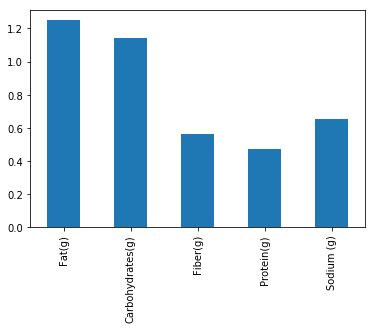

In [333]:
# SB menu mean contains more fiber
ratio = means_all.iloc[0,1:] / means_all.iloc[1,1:]
ratio.plot(kind = 'bar')